In [1]:
#Install the required libraries for pong environment
#!pip install gym==0.25.2
#!pip install "gym[atari, accept-rom-license]"

##Importing all the required packages

In [2]:
import cv2
import gym
import torch
import warnings
import numpy as np
import torch.nn as nn
from gym import spaces
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import torch.nn.functional as F
warnings.filterwarnings('ignore')

C:\Users\duvvu\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##Initiating pong environment and testing it

In [3]:
test_env = gym.make('PongNoFrameskip-v4')
print(test_env.action_space.n)

6


#Hyperparameters

In [4]:
#the boundary limit for reward to be reached by agent
reward_checkpoint = 19.0
#discount factor
gamma = 0.99
#bath size to be trained on
batch_size = 32
#learning rate
alpha = 1e-4
#epsilon greedy beginning value
eps_start = 1.0
#epsilon greedy ending value
eps_min = 0.01
#max no of times for running the env
max_timesteps = 2000000
#no of steps after which we train NN
training_startpoint = 10000
#decaying epsilon for these many timesteps
eps_decay = max_timesteps * .15
#amount of epsilon to be decremented for every timestep
eps_step = (eps_start - eps_min)/(eps_decay)

##Creating replay buffer to store (state, next_state, action, reward, done)

In [5]:
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        #maximum size of storage
        self.max_size = max_size
        #creating an empty list for storing values
        self.storage = []
        self.ptr = 0

    def add(self, data):
        if self.max_size == len(self.storage):
            self.storage[int(self.ptr)] = data
            self.ptr = (1 + self.ptr) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        #declaring empty lists to store state and next_state
        x, y = [], []
        #declaring empty lists to store action, reward and done
        u, r, d = [], [], []
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        for i in ind:
            #
            X, Y, U, R, D = self.storage[i]
            #Appending all the values to their corresponding lists
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))
        return np.array(x), np.array(y), np.array(u).reshape(-1,1), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

In [6]:
#Taking action on reset for environments that are fixed until firing
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        assert len(env.unwrapped.get_action_meanings()) >= 3
        assert 'FIRE' == env.unwrapped.get_action_meanings()[1]
        
    def step(self, ac):
        return self.env.step(ac)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

#This case for DQN and co, has been done by DeepMind for value estimation, which makes end-of-life==end-of-episode, but only reset on game over
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.lives, self.was_real_done = 0, True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        #check current lives and make loss of life terminal then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        self.was_real_done = done
        if self.lives > lives > 0:
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self):
        #reset only when lives are exhausted
        if self.was_real_done:
            obs = self.env.reset()
        else:
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        gym.Wrapper.__init__(self, env)
        shape = (2, ) + env.observation_space.shape
        self._obs_buffer = np.zeros(shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        #repeat action, sum reward and max over last observation
        done = info = None
        rewards_sum = 0.0

        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            rewards_sum += reward
            if (self._skip - 2) == i:
                self._obs_buffer[0] = obs
            if (self._skip - 1) == i:
                self._obs_buffer[1] = obs
            if done:
                break
        max_frame = self._obs_buffer.max(axis=0)
        return max_frame, rewards_sum, done, info

    def reset(self):
        return self.env.reset()

#Rewards are set to [-1, 0 +1] by its sign
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    @staticmethod
    def reward(reward):
        return np.sign(reward)

#Resizing the frmaes to 84x84 as done in the Nature paper
class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, grayscale=True):
        gym.ObservationWrapper.__init__(self, env)
        self.grayscale = grayscale
        shape = (1 if self.grayscale else 3, 84, 84)
        self.observation_space = spaces.Box(low=0, high=255, shape=shape, dtype=np.uint8)

    def observation(self, frame):
        size = (84, 84)
        if self.grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, size, interpolation=cv2.INTER_AREA)
        if self.grayscale:
            frame = np.expand_dims(frame, -1)
        return frame.transpose((2, 0, 1))

#stack the last 'k' frames and returns lazy array which is more efficient
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        obs = np.zeros((2,2))
        shp = env.observation_space.shape
        shape = shp[1:] + (shp[0] * k, ) 
        self.observation_space = spaces.Box(low=0, high=255, shape=shape, dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for u in range(self.k):
            self.frames.append(ob)
        return np.asarray(self._get_ob())

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return np.asarray(self._get_ob()), reward, done, info

    def _get_ob(self):
        assert self.k == len(self.frames)
        return LazyFrames(list(self.frames))

class LazyFrames(object):
    #The object ensures that common frames between the observation are stored only once. It exists only to optimize memory usage /
    #which can be huge for DQN's 1M frames replay buffer
    def __init__(self, frames):
        self._frames = frames
        self._out = None

    def __len__(self):
        return len(self._force())

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-3)
            self._frames = None
        return self._out

    def __getitem__(self, i):
        return self._force()[i]

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

#Configuring environment for DeepMind-style Atari
def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False):
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    env = MaxAndSkipEnv(env, skip=4)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

In [7]:
class DeepQNetwork(nn.Module):
    def __init__(self, action_size):
        super(DeepQNetwork, self).__init__()
        #we have multiple hidden layers, each with different number of layers
        hidden1 = 32
        hidden2 = 64
        hidden3 = 512
        #Using CNN for image processing and linear network later
        self.conv1 = nn.Conv2d(4, hidden1, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(hidden1, hidden2, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(hidden2, hidden2, kernel_size=3, stride=1)
        self.dense = nn.Linear(7 * 7 * hidden2, hidden3)
        self.out = nn.Linear(hidden3, action_size)

    def forward(self, x):
        #Image data is stored in the form of ints in the range of (0,255)
        x = x / 255.
        #Using relu activation function
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.dense(x.view(x.size(0), -1)))
        return self.out(x)

In [8]:
class DQNAgent():
    def __init__(self, action_size, alpha ):
        self.action_size = action_size
        self.train_net = DeepQNetwork(action_size)
        self.target_net = DeepQNetwork(action_size)
        self.target_net.load_state_dict(self.train_net.state_dict())
        self.optimizer = optim.Adam(self.train_net.parameters(), lr=alpha)
        
    def select_action(self, s, eps):
        #Following epsilon greedy method to select action
        if  eps >= np.random.rand():
            a = env.action_space.sample()
        else:
        #based on the input, greedy action is the largest Q value from the train network
            with torch.no_grad():
                input_state = torch.FloatTensor(np.array(s)).unsqueeze(0)
                a = self.train_net(input_state).max(1)[1]
        return int(a)

    #Training the network
    def train(self, replay_buffer, batch_size, gamma):
        #sample a batch from the replay buffer
        x0, x1, a, r, d = replay_buffer.sample(batch_size)
        #turn batches to tensors
        state_batch = torch.FloatTensor(x0)
        next_state_batch = torch.FloatTensor(x1)
        action_batch = torch.LongTensor(a)
        reward_batch = torch.FloatTensor(r)
        done_batch = torch.FloatTensor(1. - d)
        #obtain Q values from train net
        train_q = self.train_net(state_batch).gather(1, action_batch)
        with torch.no_grad():
            #we get argmax values from train network and use it in target network
            train_argmax = self.train_net(next_state_batch).max(1)[1].view(batch_size, 1)
            target_net_q = done_batch * gamma * self.target_net(next_state_batch).gather(1, train_argmax) + reward_batch
        #Calculate loss of train and target q values
        loss = F.smooth_l1_loss(train_q, target_net_q)
        #optimizing the parameters with the loss
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.train_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        #we return the loss to monitor it
        return loss.detach().cpu().numpy()   

    #update target network with mixture of train and target
    def update_target_network_soft(self, num_iter):
        if num_iter % 1 == 0:
            for target_var, var in zip(self.target_net.parameters(), self.train_net.parameters()):
                target_var.data.copy_((1.-0.001) * target_var.data + (0.001) * var.data)

In [9]:
#Initializing the environment
env = gym.make('PongNoFrameskip-v4')
#wrap environment
env = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True)
action_size = env.action_space.n
#Calling replay buffer with given size 
replay_buffer = ReplayBuffer(max_size=50000)
#Calling DQN agent
agent = DQNAgent(action_size, alpha)

In [10]:
state = env.reset()
episode = 1
len_episode = 0
#print stats for every these many episodes
all_stats = 10
rewards_sum = 0
stats_loss = 0.
stats_rewards = []
epsilon = eps_start

for i in range(max_timesteps):
    #picking an action from agent's policy
    action = agent.select_action(state, epsilon)
    #epsilon decay
    epsilon -= eps_step
    len_episode += 1
    if epsilon < eps_min:
        epsilon = eps_min         
    next_state, reward, done, info = env.step(action)
    rewards_sum += reward
    #adding some more experience to the replay buffer
    replay_buffer.add((state, next_state, action, reward, float(done)))
    
    if i > training_startpoint:
        stats_loss = stats_loss + agent.train(replay_buffer, batch_size, gamma)
        agent.update_target_network_soft(i)
    
    if done:
        state = env.reset()
        stats_rewards.append((episode, rewards_sum, len_episode))
        episode = 1 + episode
        len_episode = 0
        rewards_sum = 0

        #Printing all the statistical data
        if i > training_startpoint and episode % all_stats == 0:
            ax1 = np.mean(stats_rewards[-all_stats:],axis=0)[1]
            ax2 = np.mean(stats_rewards[-all_stats:],axis=0)[2]
            print('No. of Episodes: {}'.format(episode), '| Timesteps: {}'.format(i),
                '| Total Rewards: {:.1f}'.format(ax1), '| Episode length: {:.1f}'.format(ax2),
                '| Epsilon: {:.2f}'.format(epsilon), '| Loss: {:.4f}'.format(stats_loss))
            stats_loss = 0.
        
        #Setting a boundary condition for the agent when reaching the reward checkpoint (19)
        if  all_stats < len(stats_rewards) and reward_checkpoint < np.mean(stats_rewards[-all_stats:],axis=0)[1] :
            print("Stopping at episode {}".format(episode))
            print("We beat the human in {} frames, after {} games played with the average reward of {} in the last 10 games and epsilon value of {}".
                  format(i, episode, np.mean(stats_rewards[-all_stats:],axis=0)[1], epsilon))
            break  
    else:
        state = next_state

No. of Episodes: 20 | Timesteps: 17910 | Total Rewards: -20.6 | Episode length: 919.3 | Epsilon: 0.94 | Loss: 85.7967
No. of Episodes: 30 | Timesteps: 26750 | Total Rewards: -20.7 | Episode length: 884.0 | Epsilon: 0.91 | Loss: 40.1066
No. of Episodes: 40 | Timesteps: 36162 | Total Rewards: -20.4 | Episode length: 941.2 | Epsilon: 0.88 | Loss: 33.7660
No. of Episodes: 50 | Timesteps: 46609 | Total Rewards: -18.9 | Episode length: 1044.7 | Epsilon: 0.85 | Loss: 43.4776
No. of Episodes: 60 | Timesteps: 56174 | Total Rewards: -20.2 | Episode length: 956.5 | Epsilon: 0.81 | Loss: 62.5246
No. of Episodes: 70 | Timesteps: 65249 | Total Rewards: -20.6 | Episode length: 907.5 | Epsilon: 0.78 | Loss: 58.9220
No. of Episodes: 80 | Timesteps: 74394 | Total Rewards: -20.0 | Episode length: 914.5 | Epsilon: 0.75 | Loss: 54.1303
No. of Episodes: 90 | Timesteps: 84759 | Total Rewards: -19.9 | Episode length: 1036.5 | Epsilon: 0.72 | Loss: 73.2714
No. of Episodes: 100 | Timesteps: 96021 | Total Reward

In [11]:
def result(stats, length):
    cumulative = np.cumsum(np.insert(stats, 0, 0))
    calc = cumulative[length:] - cumulative[:-length]
    return (calc / length)

Text(0, 0.5, 'Length of Episode')

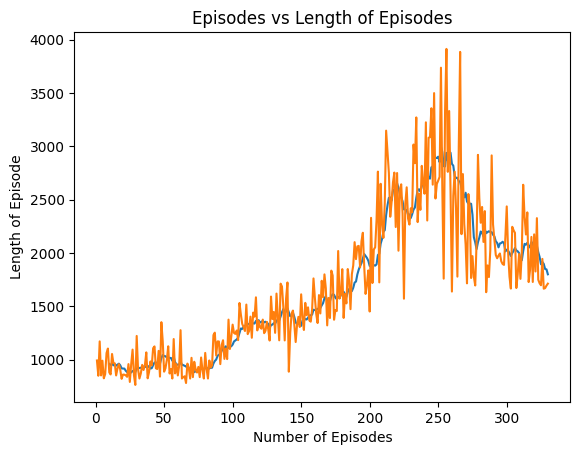

In [12]:
episode, n, l = np.array(stats_rewards).T
cumulative_l = result(l, 10)
cumulative_n = result(n, 10)

#Plotting episode lengths
plt.plot(episode[-len(cumulative_l):], cumulative_l)
plt.plot(episode, l)
plt.title("Episodes vs Length of Episodes")
plt.xlabel('Number of Episodes')
plt.ylabel('Length of Episode')

Text(0, 0.5, 'Rewards per Episode')

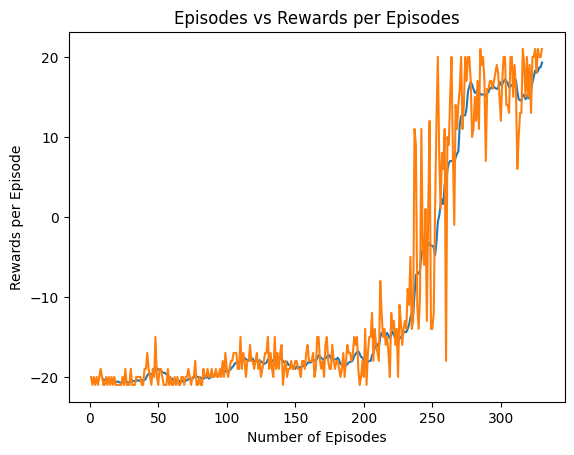

In [13]:
#Plotting rewards
plt.plot(episode[-len(cumulative_n):], cumulative_n)
plt.plot(episode, n)
plt.title("Episodes vs Rewards per Episodes")
plt.xlabel('Number of Episodes')
plt.ylabel('Rewards per Episode')